In [56]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [57]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [58]:
NUM_CLASSES = 7

# Dataset reading

In [59]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [60]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [62]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [63]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 42)                0         
                                                                 
 dense_6 (Dense)             (None, 20)                860       
                                                                 
 dropout_5 (Dropout)         (None, 20)                0         
                                                                 
 dense_7 (Dense)             (None, 10)                210       
                                                                 
 dense_8 (Dense)             (None, 7)                 77        
                                                                 
Total params: 1147 (4.48 KB)
Trainable params: 1147 (4.48 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [65]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [66]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
25/30 [========================>.....] - ETA: 0s - loss: 2.0792 - accuracy: 0.1447 
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
30/30 [==============================] - 1s 8ms/step - loss: 2.0634 - accuracy: 0.1525 - val_loss: 1.9004 - val_accuracy: 0.2543
Epoch 2/1000
24/30 [=======================>......] - ETA: 0s - loss: 1.9258 - accuracy: 0.1930
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
30/30 [==============================] - 0s 4ms/step - loss: 1.9195 - accuracy: 0.1947 - val_loss: 1.8343 - val_accuracy: 0.2804
Epoch 3/1000
 1/30 [>.............................] - ETA: 0s - loss: 1.9375 - accuracy: 0.1484

C:\Users\Mohamed Ashif\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


21/30 [====================>.........] - ETA: 0s - loss: 1.8738 - accuracy: 0.2333
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
30/30 [==============================] - 0s 4ms/step - loss: 1.8626 - accuracy: 0.2400 - val_loss: 1.7719 - val_accuracy: 0.3807
Epoch 4/1000
22/30 [=====================>........] - ETA: 0s - loss: 1.8162 - accuracy: 0.2649
Epoch 4: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
30/30 [==============================] - 0s 4ms/step - loss: 1.8147 - accuracy: 0.2666 - val_loss: 1.6962 - val_accuracy: 0.4336
Epoch 5/1000
22/30 [=====================>........] - ETA: 0s - loss: 1.7689 - accuracy: 0.2894
Epoch 5: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
30/30 [==============================] - 0s 4ms/step - loss: 1.7604 - accuracy: 0.2940 - val_loss: 1.6072 - val_accuracy: 0.4629
Epoch 6/1000
22/30 [=====================>........] - ETA: 0s - loss: 1.7004 - accuracy: 0.3054
Epoch 6: savin

In [67]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

10/10 [==============================] - 0s 684us/step - loss: 0.5496 - accuracy: 0.8791


In [68]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [69]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 47ms/step
[2.1422774e-02 6.0879448e-03 3.0524202e-04 7.0646226e-01 4.0619657e-03
 3.4889411e-02 2.2677036e-01]
3


# Confusion matrix

40/40 [==============================] - 0s 1ms/step


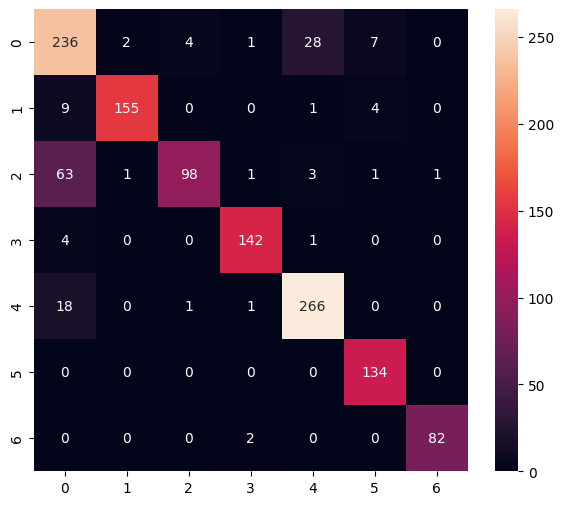

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.85      0.78       278
           1       0.98      0.92      0.95       169
           2       0.95      0.58      0.72       168
           3       0.97      0.97      0.97       147
           4       0.89      0.93      0.91       286
           5       0.92      1.00      0.96       134
           6       0.99      0.98      0.98        84

    accuracy                           0.88      1266
   macro avg       0.92      0.89      0.89      1266
weighted avg       0.89      0.88      0.88      1266



In [70]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [71]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

C:\Users\Mohamed Ashif\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [72]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\MOHAME~1\AppData\Local\Temp\tmpwotnis0u\assets


INFO:tensorflow:Assets written to: C:\Users\MOHAME~1\AppData\Local\Temp\tmpwotnis0u\assets


6704

# Inference test

In [73]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [74]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [75]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [76]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [77]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.1422777e-02 6.0879453e-03 3.0524220e-04 7.0646238e-01 4.0619648e-03
 3.4889448e-02 2.2677024e-01]
3
